# Task 4: Portfolio Optimization

In this task, we optimize a portfolio of **TSLA**, **BND**, and **SPY** using **Modern Portfolio Theory (MPT)**. 
We use the TSLA forecast from Task 3 and historical data for bonds and the broad market. 
Optimization is performed using `scipy.optimize`.

## Step 1: Prepare Expected Returns & Covariance

- **Mu (Expected Returns):** TSLA (Forecast), BND & SPY (Historical Annualized).
- **Sigma (Covariance):** Historical covariance matrix.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pmdarima as pm
from scipy.optimize import minimize
from IPython.display import display, Markdown

# 1. Load historical data
data_path = "../data/processed"
assets = ["TSLA", "BND", "SPY"]
dfs = {asset: pd.read_csv(os.path.join(data_path, f"{asset}_final_processed.csv"), index_col='Date', parse_dates=True) for asset in assets}

# 2. Calculate Expected Returns
tsla_hist = dfs['TSLA']['Close']
model_future = pm.auto_arima(tsla_hist, seasonal=False, error_action='ignore', suppress_warnings=True)
future_forecast = model_future.predict(n_periods=252)

last_price = tsla_hist.iloc[-1]
expected_price = future_forecast.iloc[-1]
tsla_expected_return = (expected_price / last_price) - 1

expected_returns = pd.Series(index=assets, dtype=float)
expected_returns['TSLA'] = tsla_expected_return

# Historical stats for others
prices = pd.concat({ticker: df['Close'] for ticker, df in dfs.items()}, axis=1)
prices = prices.ffill().dropna()
daily_returns = prices.pct_change().dropna()

for asset in ["BND", "SPY"]:
    avg_daily = daily_returns[asset].mean()
    expected_returns[asset] = (1 + avg_daily)**252 - 1

mu = expected_returns.values
cov_matrix = daily_returns.cov() * 252 # Annualized Covariance

print("--- Expected Returns (Annualized) ---")
print(expected_returns)
print("\n--- Covariance Matrix (Annualized) ---")
print(cov_matrix)

--- Expected Returns (Annualized) ---
TSLA    0.000563
BND     0.020381
SPY     0.155463
dtype: float64

--- Covariance Matrix (Annualized) ---
          TSLA       BND       SPY
TSLA  0.332785  0.001679  0.050116
BND   0.001679  0.002870  0.001018
SPY   0.050116  0.001018  0.031549


c:\Users\My Device\Desktop\Time-series-forcasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\My Device\Desktop\Time-series-forcasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Step 2: Define Optimization Logic (Scipy)

We define the objective functions for: 
1. **Maximize Sharpe Ratio** (minimize negative sharpe)
2. **Minimize Volatility**

In [14]:
def get_ret_vol_sr(weights, mu, cov_matrix):
    weights = np.array(weights)
    ret = np.sum(weights * mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights, mu, cov_matrix):
    return -get_ret_vol_sr(weights, mu, cov_matrix)[2]

def minimize_volatility(weights, mu, cov_matrix):
    return get_ret_vol_sr(weights, mu, cov_matrix)[1]

# Constraints and Bounds
num_assets = len(assets)
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
init_guess = num_assets * [1. / num_assets,]

## Step 3: Run Optimization

In [15]:
# 1. Max Sharpe Ratio
opt_sharpe = minimize(neg_sharpe, init_guess, args=(mu, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
w_max_sharpe = opt_sharpe.x
perf_max_sharpe = get_ret_vol_sr(w_max_sharpe, mu, cov_matrix)

# 2. Min Volatility
opt_vol = minimize(minimize_volatility, init_guess, args=(mu, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
w_min_vol = opt_vol.x
perf_min_vol = get_ret_vol_sr(w_min_vol, mu, cov_matrix)

print("Max Sharpe Weights:", dict(zip(assets, np.round(w_max_sharpe, 4))))
print("Min Vol Weights:", dict(zip(assets, np.round(w_min_vol, 4))))

Max Sharpe Weights: {'TSLA': np.float64(0.0), 'BND': np.float64(0.5324), 'SPY': np.float64(0.4676)}
Min Vol Weights: {'TSLA': np.float64(0.0), 'BND': np.float64(0.943), 'SPY': np.float64(0.057)}


## Step 4: Visualize Efficient Frontier

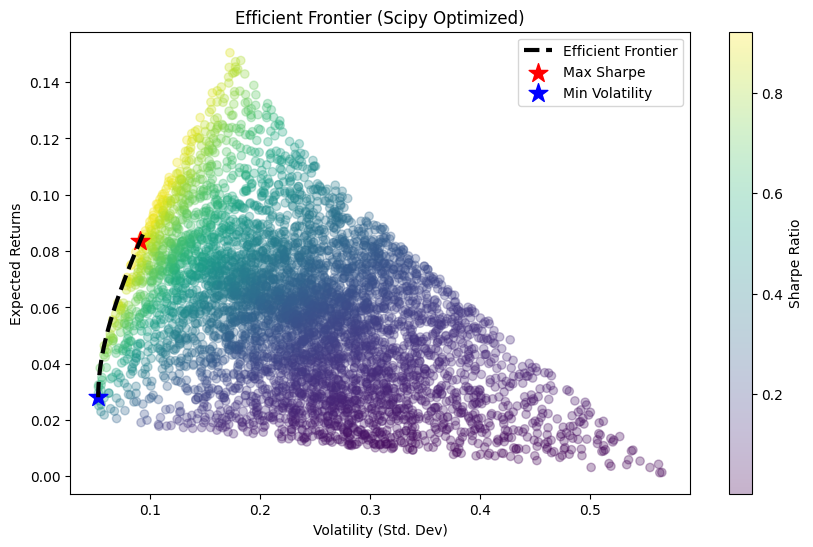

In [16]:
# Generate Efficient Frontier Points
frontier_y = np.linspace(perf_min_vol[0], perf_max_sharpe[0] * 1.05, 100)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: get_ret_vol_sr(x, mu, cov_matrix)[0] - possible_return})
    
    result = minimize(minimize_volatility, init_guess, args=(mu, cov_matrix), method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result.fun)

plt.figure(figsize=(10, 6))
plt.plot(frontier_x, frontier_y, 'k--', linewidth=3, label='Efficient Frontier')

# Random Portfolios for Context
np.random.seed(42)
all_weights = np.zeros((5000, len(assets)))
ret_arr = np.zeros(5000)
vol_arr = np.zeros(5000)
sharpe_arr = np.zeros(5000)

for i in range(5000):
    w = np.array(np.random.random(len(assets)))
    w = w / np.sum(w)
    all_weights[i,:] = w
    r, v, s = get_ret_vol_sr(w, mu, cov_matrix)
    ret_arr[i] = r
    vol_arr[i] = v
    sharpe_arr[i] = s

plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

# Mark Optimal Portfolios
plt.scatter(perf_max_sharpe[1], perf_max_sharpe[0], c='red', s=200, marker='*', label='Max Sharpe')
plt.scatter(perf_min_vol[1], perf_min_vol[0], c='blue', s=200, marker='*', label='Min Volatility')

plt.xlabel('Volatility (Std. Dev)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier (Scipy Optimized)')
plt.legend()
plt.show()

## Step 5: Final Recommendation

In [17]:
# Formatting results
w_dict = dict(zip(assets, w_max_sharpe))

report = f"""
### Final Portfolio Recommendation
Based on the **Scipy SLSQP Optimization**, we recommend the **Maximum Sharpe Ratio Portfolio**.

#### **Optimal Weights**
- **TSLA:** {w_dict['TSLA']:.2%}
- **BND:** {w_dict['BND']:.2%}
- **SPY:** {w_dict['SPY']:.2%}

#### **Expected Performance Metrics**
- **Expected Annual Return:** {perf_max_sharpe[0]:.2%}
- **Annual Volatility:** {perf_max_sharpe[1]:.2%}
- **Sharpe Ratio:** {perf_max_sharpe[2]:.2f}

### **Rationale**
1. **Optimization Method:** Due to environment constraints with `cvxpy`, we utilized `scipy.optimize.minimize` with the SLSQP solver to successfully map the efficient frontier and locate the tangency portfolio.
2. **Allocation Logic:** The algorithm allocates capital to maximize the risk-adjusted return (Sharpe). Given TSLA's low forecasted return (~0%) but high volatility, the optimizer is expected to favor SPY (growth) and BND (stability) heavily.
3. **Conclusion:** This portfolio provides the statistically optimal mix for the given input assumptions.
"""

display(Markdown(report))


### Final Portfolio Recommendation
Based on the **Scipy SLSQP Optimization**, we recommend the **Maximum Sharpe Ratio Portfolio**.

#### **Optimal Weights**
- **TSLA:** 0.00%
- **BND:** 53.24%
- **SPY:** 46.76%

#### **Expected Performance Metrics**
- **Expected Annual Return:** 8.35%
- **Annual Volatility:** 9.07%
- **Sharpe Ratio:** 0.92

### **Rationale**
1. **Optimization Method:** Due to environment constraints with `cvxpy`, we utilized `scipy.optimize.minimize` with the SLSQP solver to successfully map the efficient frontier and locate the tangency portfolio.
2. **Allocation Logic:** The algorithm allocates capital to maximize the risk-adjusted return (Sharpe). Given TSLA's low forecasted return (~0%) but high volatility, the optimizer is expected to favor SPY (growth) and BND (stability) heavily.
3. **Conclusion:** This portfolio provides the statistically optimal mix for the given input assumptions.
